In [1]:
#from data_processing.neural_networks.LSTM_Long_Short_Term_Memory.LSTM_torch_class import LSTM_torch
#from data_processing.neural_networks.nn_helper_functions import init_weights_LSTM as init_weights
import torch
import torch.nn as nn
from torch.optim import Adam
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch.utils.tensorboard import SummaryWriter
#tensorboard --logdir 'runs\LSTM_pytorch_full' --host localhost --port 8888
from IPython.display import clear_output
clear_output()

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
clear_output()

# Solved case using pytorch [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) and a [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layer.
* Model reads sequence and predicts next entry.
* Can predict further by updating sequence with previous prediction and reusing model.
## Read data & (OPTIONAL) check trends



torch.Size([132, 3])

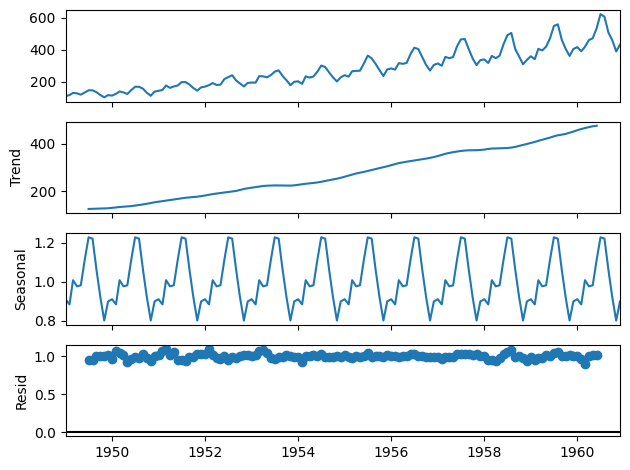

In [3]:
df = pd.read_csv(os.path.join('data_processing','media','airline-passengers.csv'), index_col=0, parse_dates=True)
timeseriesOG    = torch.tensor(df["Passengers"].values, dtype = torch.float, device=device).reshape(-1,1)
result          = seasonal_decompose(df, model='multiplicative')
result.plot();

data_trend      = result.trend.to_numpy()[6:-6]
data_seasonal   = result.seasonal.to_numpy()[6:-6]
data_residual   = result.resid.to_numpy()[6:-6]
LEN_DATA = len(data_trend)

data_trend      = torch.tensor(data_trend   , device = device, dtype = torch.float)
data_seasonal   = torch.tensor(data_seasonal, device = device, dtype = torch.float)
data_residual   = torch.tensor(data_residual, device = device, dtype = torch.float)
data_concat     = torch.vstack([data_trend,data_seasonal,data_residual]).T
data_concat.shape

## Prepare training and "validaion" slices of data

For training $\rightarrow$ 1 step ahead.
* slice(from, to, step), 'to' not included
* get all data except last element

In [4]:
LOOKBACK = 30
slices_train = [slice(i,i + LOOKBACK,1) for i in range(LEN_DATA - LOOKBACK + 1)]
NUM_SLICES = len(slices_train)
slices_train[-1], data_trend.shape, data_trend[slices_train[-1]].shape

(slice(102, 132, 1), torch.Size([132]), torch.Size([30]))

For testing `N_FORWARD` steps ahead.
* get up to last `N_FORWARD` entries
* generate input slice and output slice

In [5]:
N_FORWARD = 10
slices_test_input    = [slice(i              , i + LOOKBACK              , 1) for i in range(LEN_DATA - LOOKBACK + 1 - N_FORWARD)]
slices_test_output   = [slice(i + LOOKBACK   , i + LOOKBACK + N_FORWARD  , 1) for i in range(LEN_DATA - LOOKBACK + 1 - N_FORWARD)]
slices_test_input[-1], slices_test_output[-1]

(slice(92, 122, 1), slice(122, 132, 1))

C:\Users\Hot Mexican\AppData\Local\Temp\ipykernel_13956\3024994491.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:264.)
  batch_x = torch.tensor([train_data[sl       ] for sl in slices_train[:-1]], dtype=torch.float).to(device).unsqueeze(-1)


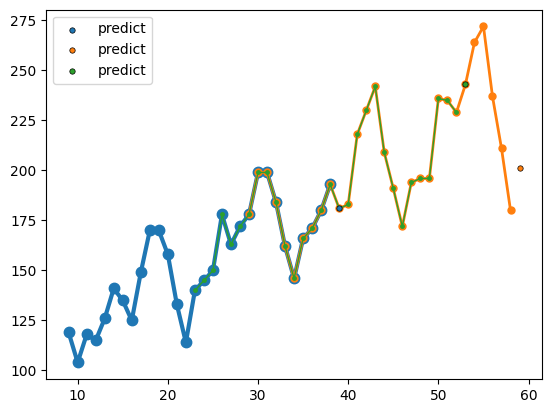

In [6]:
torch.manual_seed(7)
train_data = df["Passengers"].values
# last slice has no prediction
batch_x = torch.tensor([train_data[sl       ] for sl in slices_train[:-1]], dtype=torch.float).to(device).unsqueeze(-1) 
batch_y = torch.tensor([train_data[[sl.stop]] for sl in slices_train[:-1]], dtype=torch.float).to(device).unsqueeze(-1)
batch_x.shape, batch_y.shape
#ID_shuffle      = torch.randperm(batch_x.size(0))
ID_shuffle = torch.arange(batch_x.size(0))
batch_x_shuffle = batch_x[ID_shuffle]
batch_y_shuffle = batch_y[ID_shuffle]
sc = 1
#plt.plot(train_data)
P = 3
s = 1
i1 = range(P)
i2 = torch.arange(P,0,-1)*s
gg =  torch.randperm(batch_x.size(0))[:P]
for k,size,g in zip(i1,i2,gg):
   
    x_from = ID_shuffle[g]
    x = range(x_from, x_from + batch_x.shape[1],1)
    p = plt.plot(x, batch_x_shuffle[g].cpu().numpy(), '.', ms = 5*size)
    c = p[0].get_color()
    plt.plot(x, batch_x_shuffle[g].cpu().numpy(), '-', c= c, lw = size)
    plt.scatter([x_from + batch_x.shape[1]], batch_y_shuffle[g].cpu().numpy(),
                c= c,edgecolor ='k',linewidths= 0.5, s=15, zorder = 10, label ='predict')
plt.legend()

### Backup model w/o batching

In [70]:
# class LSTM(nn.Module):

#     def __init__(self, num_features, hidden_dim):
#         super().__init__()
#         self.hidden_size = hidden_dim
#         self.num_features = num_features

#         self.lstm       = nn.LSTM(num_features, hidden_dim)
#         self.lin = nn.Linear(hidden_dim, num_features)

#     def forward(self,  data):
#         return self.calc(data)[0]
    
#     def calc(self,dataset, c0 = None, h0 = None):
#         (c0, h0) = torch.zeros(size = (2,1,self.hidden_size), device=device, dtype = torch.float) if c0 is None else (c0, h0)
#         out, states_out = self.lstm(dataset, (c0, h0))
#         out = self.lin(out[-1])
#         return  out, states_out 
    
#     @torch.no_grad()
#     def test(self, dataset, iter_input, iter_output):
#         buffer          = dataset[iter_input].clone()
#         data_buffer_old = buffer.clone()
#         (ck, hk)        = torch.zeros(size = (2, 1, self.hidden_size), dtype = torch.float, device=device)
#         predict = torch.zeros(size = (N_FORWARD, self.num_features))
#         for i in range(N_FORWARD):
#             out, (ck, hk) = self.calc(buffer, ck, hk)
#             (ck, hk)        = torch.zeros(size = (2, 1, self.hidden_size), dtype = torch.float, device=device)
#             predict[i]  = out   
#             buffer[:-1] = data_buffer_old[1:]
#             buffer[-1]  = out
#             data_buffer_old = buffer.clone()

#         fig, axs = plt.subplots(self.num_features, 1, figsize = (10,3.3), layout='constrained')
#         axs = [axs] if self.num_features == 1 else axs
#         for k, ax in enumerate(axs):
#             ax.plot(range(LOOKBACK)                     , dataset[iter_input][:,k]    .cpu().numpy(), c='red'  , label = 'True prev')
#             ax.plot(range(LOOKBACK, LOOKBACK+ N_FORWARD), dataset[iter_output][:,k]   .cpu().numpy(), c='green', label = 'True post')
#             ax.plot(range(LOOKBACK, LOOKBACK+ N_FORWARD), predict[:,k]                .cpu().numpy(), c='blue' , label = 'Predict')
#         #plt.show()
        

# HIDDEN_SIZE = 100
# saved_state_path = os.path.join('data_processing','neural_networks', 'save_states', 'LSTM', f'pytorch_full_{HIDDEN_SIZE}_{train_data.size(1)}.pht')

# net = LSTM(train_data.size(1),HIDDEN_SIZE).to(device)

# if os.path.exists(saved_state_path):
#     saved_state_dict = torch.load(saved_state_path)
#     net.load_state_dict(saved_state_dict)

# criterion = nn.MSELoss()
# optimizer = Adam(net.parameters(), lr = 1e-4)#, weight_decay=1e-5)

# s=  10
# net(train_data[slices_train[s]]).shape
# net.test(train_data, slices_test_input[s], slices_test_output[s])

### Batched pytorch model

In [76]:
class LSTM(nn.Module):

    def __init__(self, num_features, hidden_dim, batch_first = True): 
        super().__init__()
        self.hidden_size = hidden_dim
        self.num_features = num_features
        self.batch_first  = batch_first
        self.lstm = nn.LSTM(num_features, hidden_dim, batch_first=batch_first)
        self.lin  = nn.Linear(hidden_dim, num_features)
        self.report_dims = True

    def forward(self,  data):
        
        N = data.size(0) if self.batch_first else data.size(1)
        h0, c0 = torch.tensor(0),torch.tensor(0)
        # if self.batch_first is not None:
        #     (h0, c0) = torch.zeros(size = (2, 1, N, self.hidden_size), device=device, dtype = torch.float)
        # h,c = self.lstm(data, (h0, c0))[1]
        h,c = self.lstm(data)[1]
        out = self.lin(h)
        if self.report_dims: self.report(data , h0, c0, h, c, out)
        return  out, (h,c) 
    
    def report(self, data , h0, c0, h, c, out):
        print(f'{data.shape = }, {h0.shape = }, {c0.shape = }, {h.shape = }, {c.shape = }, {out.shape = }')
        self.report_dims = False

    def calc(self,dataset, c0 = None, h0 = None):
        (c0, h0) = torch.zeros(size = (2,1,self.hidden_size), device=device, dtype = torch.float) if c0 is None else (c0, h0)
        out, states_out = self.lstm(dataset, (c0, h0))
        out = self.lin(out[-1])
        return  out, states_out 
    
    @torch.no_grad()
    def test0(self, dataset, iter_input, iter_output):
        
        out, (ck, hk) = self.forward(dataset[iter_input].clone())
        out = out.reshape(1,1)
        predict = torch.zeros(size = (N_FORWARD, self.num_features))
        for i in range(N_FORWARD):
            predict[i]  = out  
            out, (ck, hk) = self.lstm(out, (ck, hk))
            out = self.lin(out[-1]).reshape(1,1)

        fig, axs = plt.subplots(self.num_features, 1, figsize = (10,3.3), layout='constrained')
        axs = [axs] if self.num_features == 1 else axs
        for k, ax in enumerate(axs):
            ax.plot(range(LOOKBACK)                     , dataset[iter_input][:,k]    .cpu().numpy(), c='red'  , label = 'True prev')
            ax.plot(range(LOOKBACK, LOOKBACK+ N_FORWARD), dataset[iter_output][:,k]   .cpu().numpy(), c='green', label = 'True post')
            ax.plot(range(LOOKBACK, LOOKBACK+ N_FORWARD), predict[:,k]                .cpu().numpy(), c='blue' , label = 'Predict')
        #plt.show()

    @torch.no_grad()
    def test(self, x, y):
        """ Do one seq lstm run. Shift old seq to left and append prediction. REPEAT with zero c&h = default"""
        N = x.size(0) if self.batch_first else x.size(1)
        x1 = x.clone()
        # if self.batch_first is not None:
        #     (h0, c0) = torch.zeros(size = (2, 1, N, self.hidden_size), device=device, dtype = torch.float)
        # _, states_out = self.lstm(x1, (h0, c0)) # out- hs for all time steps. states_out - final h and c
        _, states_out = self.lstm(x1) # out- hs for all time steps. states_out - final h and c

        # h_hist = torch.zeros(size = (N, N_FORWARD + 1, self.hidden_size), device=device, dtype = torch.float)
        # c_hist = torch.zeros(size = (N, N_FORWARD + 1, self.hidden_size), device=device, dtype = torch.float)

        # h_hist[0,0] = states_out[0][0,0]
        # c_hist[0,0] = states_out[1][0,0]

        x_next = self.lin(states_out[0])

        predict = torch.zeros(size = (N, N_FORWARD + 1, self.num_features))
        predict[0,0] = x_next[0,0]

        for i in range(N_FORWARD):
            x1[:,:-1]        = x1[:,1:].clone()
            x1[:,-1]         = x_next[0]
            # (h0, c0) = h_hist[:,[i]], c_hist[:,[i]]
            # _, states_out   = self.lstm(x1, (h0, c0))
            _, states_out   = self.lstm(x1)
            x_next          = self.lin(states_out[0])
            predict[0   ,i+1] = x_next[0,0]
            # h_hist[0    ,i+1] = states_out[0][0,0]
            # c_hist[0    ,i+1] = states_out[1][0,0]

        fig, axs = plt.subplots(self.num_features, 1, figsize = (10,3.3), layout='constrained')
        axs = [axs] if self.num_features == 1 else axs
        for k, ax in enumerate(axs):
            ax.plot(range(LOOKBACK)                     , x.flatten().cpu().numpy(), c='red'  , label = 'True prev')
            ax.plot(range(LOOKBACK, LOOKBACK+ N_FORWARD), y.flatten()   .cpu().numpy(), c='green', label = 'True post')
            ax.plot(range(LOOKBACK, LOOKBACK+ N_FORWARD), predict.flatten()[:-1].cpu().numpy(), c='blue' , label = 'Predict')
        #plt.show()
        

# Train model
learn to predict 1 step ahead
test by predicting N_FORWARD steps into future

## Pytorch OG model with batch = 1: ~ 3.5 k iter to e02 loss
* slow epoch
* fast global convergence

In [105]:
HIDDEN_SIZE = 100
saved_state_path = os.path.join('data_processing','neural_networks', 'save_states', 'LSTM', f'pytorch_LSTM_B01_H{HIDDEN_SIZE}.pht')

LSTB_Batched_01 = LSTM(batch_x.size(2), HIDDEN_SIZE).to(device)

if os.path.exists(saved_state_path):
    saved_state_dict = torch.load(saved_state_path)
    LSTB_Batched_01.load_state_dict(saved_state_dict)

criterion = nn.MSELoss()
optimizer = Adam(LSTB_Batched_01.parameters(), lr = 1e-4)#, weight_decay=1e-5)

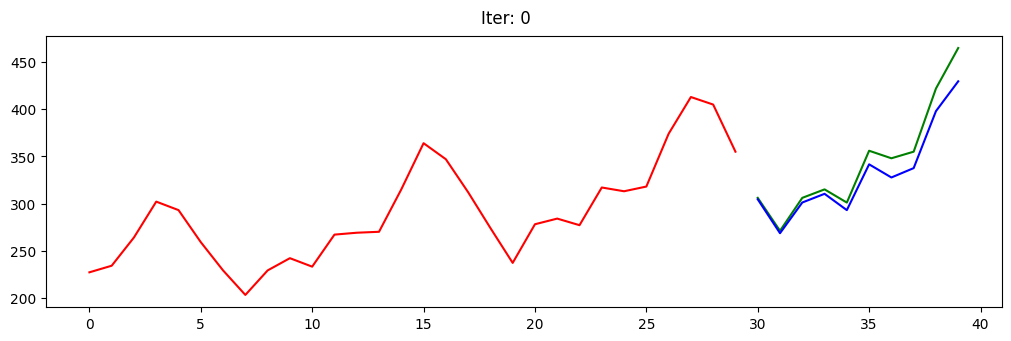

iter:0, 1.220e+03


In [106]:
NUM_EPOCHS = 1
LSTB_Batched_01.report_dims = True
now = datetime.datetime.now()
s2 = now.strftime("%H_%M_%S")
writer = SummaryWriter(os.path.join('runs', 'LSTM_pytorch_full', s2))
step = 0


minibatches = True

for i in range(NUM_EPOCHS):

    ID_shuffle      = torch.randperm(batch_x.size(0))
    batch_x_shuffle = batch_x[ID_shuffle]
    batch_y_shuffle = batch_y[ID_shuffle]

    if minibatches:
        minbatch_size = 1
        minbatches_x = torch.split(batch_x_shuffle, minbatch_size, dim=0)
        minbatches_y = torch.split(batch_y_shuffle, minbatch_size, dim=0)
        
        loss2 = 0

        for x,y in zip(minbatches_x,minbatches_y):
            output = LSTB_Batched_01(x)[0] # [1, minibatch, features]
            y = y.view(1,-1,1)          # remap [minibatch, feats, 1] to output dims
            loss   = criterion(output, y)   
            loss2 += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    else:   
        x = LSTB_Batched_01(batch_x_shuffle)[0]
        y = batch_y.view(1,-1,1)  
        loss   = criterion(x, y)
        loss2 = loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # test prediction of N steps forward
    if i % 500 == 0 :#and i > 0:
        clear_output()
        s = torch.randint(0, len(slices_test_input) - 1, size = (1,)).item()
        x = torch.tensor([train_data[slices_test_input[s]]] , dtype=torch.float).to(device).reshape(1,-1,1) 
        y = torch.tensor([train_data[slices_test_output[s]]], dtype=torch.float).to(device).reshape(1,-1,1) 
        LSTB_Batched_01.test(x, y)
        plt.suptitle(f'Iter: {i}')
        plt.show()
       
    if i % 999 == 0 and i > 1:
         torch.save(LSTB_Batched_01.state_dict(), saved_state_path)
    writer.add_scalar('Training Loss', loss2, global_step=step)
    step += 1
    if i % 100 == 0:
        with torch.no_grad():
            print(f'iter:{i}, {loss2:0.3e}')

## Pytorch OG model with batch = 20: ~ 20 k iter to e02 loss
* fast epoch
* need alot of epochs

In [97]:
saved_state_path = os.path.join('data_processing','neural_networks', 'save_states', 'LSTM', f'pytorch_LSTM_B20_H{HIDDEN_SIZE}.pht')

LSTB_Batched_20 = LSTM(batch_x.size(2), HIDDEN_SIZE).to(device)

if os.path.exists(saved_state_path):
    saved_state_dict = torch.load(saved_state_path)
    LSTB_Batched_20.load_state_dict(saved_state_dict)

optimizer = Adam(LSTB_Batched_20.parameters(), lr = 1e-4)
iters = 0

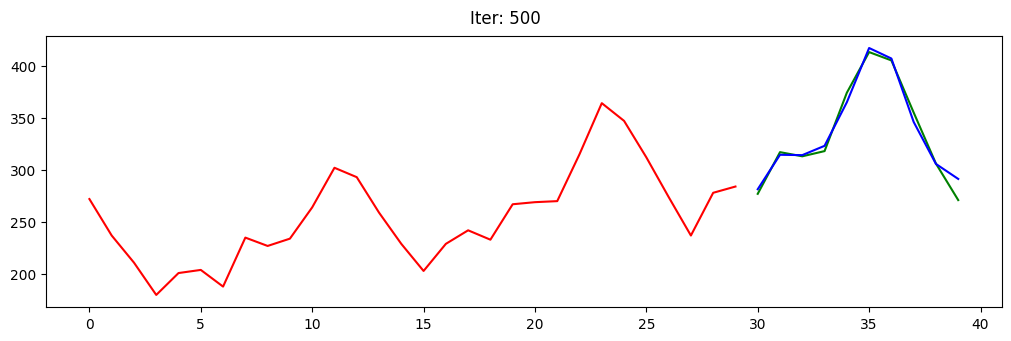

iters = 502; step = 501, loss: 3.581e+02


In [99]:
NUM_EPOCHS = 501
LSTB_Batched_20.report_dims = True
now = datetime.datetime.now()
s2 = now.strftime("%H_%M_%S")
writer = SummaryWriter(os.path.join('runs', 'LSTM_pytorch_full', s2))
step = 0


minibatches = True

for i in range(NUM_EPOCHS):

    ID_shuffle      = torch.randperm(batch_x.size(0))
    batch_x_shuffle = batch_x[ID_shuffle]
    batch_y_shuffle = batch_y[ID_shuffle]

    if minibatches:
        minbatch_size = 20
        minbatches_x = torch.split(batch_x_shuffle, minbatch_size, dim=0)
        minbatches_y = torch.split(batch_y_shuffle, minbatch_size, dim=0)
        
        loss2 = 0

        for x,y in zip(minbatches_x,minbatches_y):
            output = LSTB_Batched_20(x)[0] # [1, minibatch, features]
            y = y.view(1,-1,1)          # remap [minibatch, feats, 1] to output dims
            loss   = criterion(output, y)   
            loss2 += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    else:   
        x = LSTB_Batched_20(batch_x_shuffle)[0]
        y = batch_y.view(1,-1,1)  
        loss   = criterion(x, y)
        loss2 = loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # test prediction of N steps forward
    if i % 500 == 0 :#and i > 0:
        clear_output()
        s = torch.randint(0, len(slices_test_input) - 1, size = (1,)).item()
        x = torch.tensor([train_data[slices_test_input[s]]] , dtype=torch.float).to(device).reshape(1,-1,1) 
        y = torch.tensor([train_data[slices_test_output[s]]], dtype=torch.float).to(device).reshape(1,-1,1) 
        LSTB_Batched_20.test(x, y)
        plt.suptitle(f'Iter: {i}')
        plt.show()
       
    if i % 999 == 0 and i > 1:
         torch.save(LSTB_Batched_20.state_dict(), saved_state_path)
    writer.add_scalar('Training Loss', loss2, global_step=step)
    step += 1
    iters += 1
    if i % 100 == 0:
        with torch.no_grad():
            print(f'{iters = }; {step = }, loss: {loss2:0.3e}')

## Pytorch OG model with mono batch : ~ 15 k iter to e02 loss
* fast epoch
* need a lot of epochs. better than batch 20.

In [107]:
saved_state_path = os.path.join('data_processing','neural_networks', 'save_states', 'LSTM', f'pytorch_LSTM_BALL_H{HIDDEN_SIZE}.pht')

LSTB_Batched_all = LSTM(batch_x.size(2), HIDDEN_SIZE).to(device)

if os.path.exists(saved_state_path):
    saved_state_dict = torch.load(saved_state_path)
    LSTB_Batched_all.load_state_dict(saved_state_dict)

criterion = nn.MSELoss()
optimizer = Adam(LSTB_Batched_all.parameters(), lr = 1e-4)#, weight_decay=1e-5)

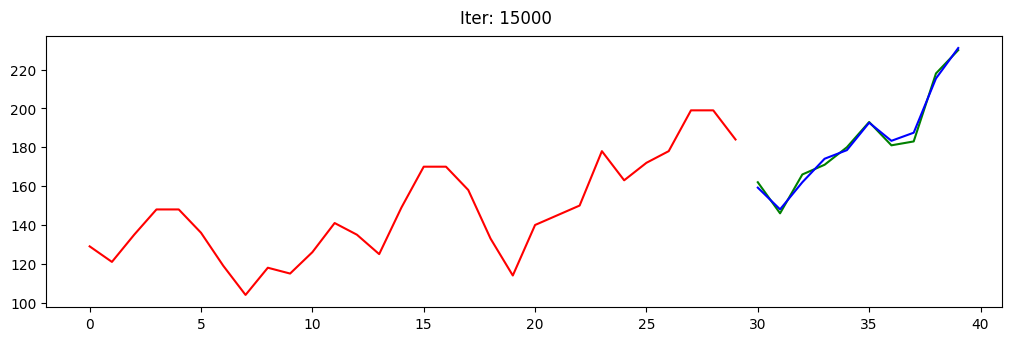

iters = 15503; step = 15001, loss: 9.016e+02
iters = 15603; step = 15101, loss: 6.172e+02
iters = 15703; step = 15201, loss: 6.292e+02
iters = 15803; step = 15301, loss: 2.057e+03
iters = 15903; step = 15401, loss: 7.719e+02
iters = 16003; step = 15501, loss: 6.848e+02
iters = 16103; step = 15601, loss: 4.912e+02
iters = 16203; step = 15701, loss: 9.516e+02


KeyboardInterrupt: 

In [108]:
NUM_EPOCHS = 40501
LSTB_Batched_all.report_dims = True
now = datetime.datetime.now()
s2 = now.strftime("%H_%M_%S")
writer = SummaryWriter(os.path.join('runs', 'LSTM_pytorch_full', s2))
step = 0


minibatches = True

for i in range(NUM_EPOCHS):

    ID_shuffle      = torch.randperm(batch_x.size(0))
    batch_x_shuffle = batch_x[ID_shuffle]
    batch_y_shuffle = batch_y[ID_shuffle]

    if minibatches:
        minbatch_size = 20
        minbatches_x = torch.split(batch_x_shuffle, minbatch_size, dim=0)
        minbatches_y = torch.split(batch_y_shuffle, minbatch_size, dim=0)
        
        loss2 = 0

        for x,y in zip(minbatches_x,minbatches_y):
            output = LSTB_Batched_all(x)[0] # [1, minibatch, features]
            y = y.view(1,-1,1)          # remap [minibatch, feats, 1] to output dims
            loss   = criterion(output, y)   
            loss2 += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    else:   
        x = LSTB_Batched_all(batch_x_shuffle)[0]
        y = batch_y.view(1,-1,1)  
        loss   = criterion(x, y)
        loss2 = loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # test prediction of N steps forward
    if i % 2500 == 0 :#and i > 0:
        clear_output()
        s = torch.randint(0, len(slices_test_input) - 1, size = (1,)).item()
        x = torch.tensor([train_data[slices_test_input[s]]] , dtype=torch.float).to(device).reshape(1,-1,1) 
        y = torch.tensor([train_data[slices_test_output[s]]], dtype=torch.float).to(device).reshape(1,-1,1) 
        LSTB_Batched_all.test(x, y)
        plt.suptitle(f'Iter: {i}')
        plt.show()
       
    if i % 999 == 0 and i > 1:
         torch.save(LSTB_Batched_all.state_dict(), saved_state_path)
    writer.add_scalar('Training Loss', loss2, global_step=step)
    step += 1
    iters += 1
    if i % 100 == 0:
        with torch.no_grad():
            print(f'{iters = }; {step = }, loss: {loss2:0.3e}')

In [18]:
class FakeLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.num_features = input_size
        self.hidden_size  = hidden_size

        self.Wi         = nn.Linear(in_features=input_size  , out_features=4*hidden_size, bias=False, device=device)
        self.Wh         = nn.Linear(in_features=hidden_size , out_features=4*hidden_size, bias=True , device=device)

        self.sigmoid    = nn.Sigmoid()
        self.tanh       = nn.Tanh()

        self.lin        = nn.Linear(hidden_size, input_size)
        self.batch_first = True
    
    def LSTM_PASS(self, x_t, h_prev, c_prev):
        #L = batch size; NUM_FEATS - input size; NUM_HIDD - hidden size
        # [1, L, 4*NUM_HIDD] = [1, L, NUM_FEATS] x [NUM_FEATS, 4*NUM_HIDD] + [1, L, NUM_FEATS] x [NUM_HIDD, 4*NUM_HIDD]
        gates = self.Wi(x_t) + self.Wh(h_prev)
        # [1, L, NUM_HIDD], [1, L, NUM_HIDD], [1, L, NUM_HIDD], [1, L, NUM_HIDD]
        gate_input, gate_forget, gate_cell, gate_output = gates.chunk(4, dim = 2) #[1, L, 4*NUM_HIDD] -> 4x

        gate_input  = self.sigmoid(  gate_input )
        gate_forget = self.sigmoid(  gate_forget)
        gate_cell   = self.tanh(     gate_cell  )
        gate_output = self.sigmoid(  gate_output)

        c_t         = gate_forget * c_prev + gate_input * gate_cell
        h_t         = gate_output * self.tanh(gate_cell)

        # [1, L, NUM_HIDD], [1, L, NUM_HIDD]
        return  h_t, c_t
    
    def forward(self, dataset):
        BATCH_SIZE, SEQ_LENGTH, NUM_FEATURES = dataset.size()
        NUM_HIDDEN = self.hidden_size
        c_t = torch.zeros((1, BATCH_SIZE, NUM_HIDDEN), device=device, dtype=torch.float)
        h_t = torch.zeros((1, BATCH_SIZE, NUM_HIDDEN), device=device, dtype=torch.float)
        history_ch = [(h_t, c_t)]
        
        for i in range(SEQ_LENGTH):
            x_t = dataset[:,i].unsqueeze(0)    # [1, batch, feature]
            (h_t, c_t) = history_ch[-1]
            h2_t, c2_t = self.LSTM_PASS(x_t, h_t, c_t)
            history_ch.append((h2_t, c2_t))

        final = self.lin(h2_t)
        return final, (h2_t, c2_t)
    
    @torch.no_grad()
    def test(self, x, y):
        """ Do one seq lstm run. Shift old seq to left and append prediction. REPEAT with zero c&h = default"""
        N = x.size(0) if self.batch_first else x.size(1)
        x_t = x.clone()
        predict = torch.zeros(size = (N, N_FORWARD, self.num_features))

        for i in range(N_FORWARD):
            x_next   = self.forward(x_t)[0] 
            predict[0 ,i]       = x_next[0,0]
            x_t[:,:-1]          = x_t[:,1:].clone()
            x_t[:,-1]           = x_next[0]

        fig, ax = plt.subplots(self.num_features, 1, figsize = (10,3.3), layout='constrained')
        ax.plot(range(LOOKBACK)                     , x         .flatten().cpu().numpy(), c='red'  , label = 'True prev')
        ax.plot(range(LOOKBACK, LOOKBACK+ N_FORWARD), y         .flatten().cpu().numpy(), c='green', label = 'True post')
        ax.plot(range(LOOKBACK, LOOKBACK+ N_FORWARD), predict   .flatten().cpu().numpy(), c='blue' , label = 'Predict')


HIDDEN_SIZE = 100

saved_state_path = os.path.join('data_processing','neural_networks', 'save_states', 'LSTM', f'pytorch_custom_{HIDDEN_SIZE}.pht')

LSTM_custom = FakeLSTM(1, HIDDEN_SIZE).to(device)

load_weights = True
if os.path.exists(saved_state_path) and load_weights:
    saved_state_dict = torch.load(saved_state_path)
    LSTM_custom.load_state_dict(saved_state_dict)

criterion = nn.MSELoss()
optimizer = Adam(LSTM_custom.parameters(), lr = 1e-3)#, weight_decay=1e-5)
iters = 0

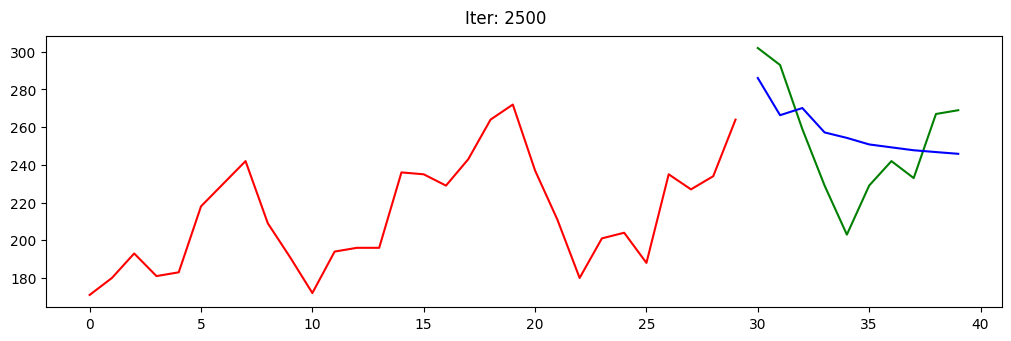

iters = 2501; step = 2501, loss: 2.826e+04, minibatches = True
iters = 2601; step = 2601, loss: 2.768e+04, minibatches = True
iters = 2701; step = 2701, loss: 2.580e+04, minibatches = True
iters = 2801; step = 2801, loss: 2.578e+04, minibatches = True
iters = 2901; step = 2901, loss: 2.387e+04, minibatches = True
iters = 3001; step = 3001, loss: 2.358e+04, minibatches = True
iters = 3101; step = 3101, loss: 2.310e+04, minibatches = True
iters = 3201; step = 3201, loss: 1.978e+04, minibatches = True
iters = 3301; step = 3301, loss: 2.233e+04, minibatches = True
iters = 3401; step = 3401, loss: 2.575e+04, minibatches = True
iters = 3501; step = 3501, loss: 2.485e+04, minibatches = True
iters = 3601; step = 3601, loss: 2.448e+04, minibatches = True
iters = 3701; step = 3701, loss: 2.364e+04, minibatches = True
iters = 3801; step = 3801, loss: 2.124e+04, minibatches = True
iters = 3901; step = 3901, loss: 2.137e+04, minibatches = True


In [19]:
NUM_EPOCHS = 4000
#LSTB_Batched_all.report_dims = True
now = datetime.datetime.now()
s2 = now.strftime("%H_%M_%S")
writer = SummaryWriter(os.path.join('runs', 'LSTM_pytorch_full', s2))
step = 0

for i in range(NUM_EPOCHS):
    p = torch.rand(1)[0]
    minibatches = True #if p > 10.8 else False    
    ID_shuffle      = torch.randperm(batch_x.size(0))
    batch_x_shuffle = batch_x[ID_shuffle]
    batch_y_shuffle = batch_y[ID_shuffle]

    if minibatches:
        minbatch_size = 3
        minbatches_x = torch.split(batch_x_shuffle, minbatch_size, dim=0)
        minbatches_y = torch.split(batch_y_shuffle, minbatch_size, dim=0)
        
        loss2 = 0

        for x,y in zip(minbatches_x,minbatches_y):
            output = LSTM_custom(x)[0] # [1, minibatch, features]
            y = y.view(1,-1,1)          # remap [minibatch, feats, 1] to output dims
            loss   = criterion(output, y)   
            loss2 += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    else:   
        x = LSTM_custom(batch_x_shuffle)[0] # [1, batch, feature]
        y = batch_y.view(1,-1,1)  
        loss   = criterion(x, y)
        loss2 = loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # test prediction of N steps forward
    if i % 2500 == 0 :#and i > 0:
        LSTM_custom.eval()
        clear_output()
        s = torch.randint(0, len(slices_test_input) - 1, size = (1,)).item()
        x = torch.tensor([train_data[slices_test_input[s]]] , dtype=torch.float).to(device).reshape(1,-1,1) 
        y = torch.tensor([train_data[slices_test_output[s]]], dtype=torch.float).to(device).reshape(1,-1,1) 
        LSTM_custom.test(x, y)
        plt.suptitle(f'Iter: {i}')
        plt.show()
        LSTM_custom.train()
       
    if i % 999 == 0 and i > 1:
         torch.save(LSTM_custom.state_dict(), saved_state_path)
    writer.add_scalar('Training Loss', loss2, global_step=step)
    step += 1
    iters += 1
    if i % 100 == 0:
        with torch.no_grad():
            print(f'{iters = }; {step = }, loss: {loss2:0.3e}, {minibatches = }')

In [27]:
NUM_EPOCHS = 1

now = datetime.datetime.now()
s2 = now.strftime("%H_%M_%S")
writer = SummaryWriter(os.path.join('runs', 'LSTM_pytorch_full', s2))
step = 0

for i in range(NUM_EPOCHS):
    optimizer.zero_grad()

    ID_shuffle      = torch.randperm(batch_x.size(0))
    batch_x_shuffle = batch_x[ID_shuffle]   #[batch, seq, feature]
    batch_y_shuffle = batch_y[ID_shuffle]

    output = LSTM_custom(batch_x_shuffle)[0]
    loss   = criterion(output, batch_y_shuffle)
    loss.backward()
    optimizer.step()

    # test prediction of N steps forward
    if i % 200 == 0:
        clear_output()
        with torch.no_grad():
            print(f'{loss.item():0.3e}')
        s = torch.randint(0, len(slices_test_input) - 1, size = (1,)).item()
        
        x = torch.tensor([train_data[slices_test_input[s]]] , dtype=torch.float).to(device).reshape(1, LOOKBACK, 1) 
        y = torch.tensor([train_data[slices_test_output[s]]], dtype=torch.float).to(device).reshape(1, N_FORWARD, 1) 
        LSTM_custom.test(x, y)
        plt.suptitle(f'Iter: {i}')
        plt.show()
       
    if i % 500 == 0 and i > 1 and 1 == -1:
         torch.save(LSTM_custom.state_dict(), saved_state_path)
         #clear_output()
    writer.add_scalar('Training Loss', loss, global_step=step)
    step += 1
    # with torch.no_grad():
    #     print(f'{loss.item():0.3e}')

9.789e+04


ValueError: too many values to unpack (expected 2)

In [111]:
    # @torch.no_grad()
    # def test_unroll(self,x, y):
    #     x_next, ck, hk        = self.forward(x)
    #     predict = torch.zeros(size = (N_FORWARD + 1, self.num_features))
    #     predict[0] = x_next
    #     for i in range(N_FORWARD):
    #         ck, hk = self.LSTM_PASS(x_next, ck, hk)
    #         predict[i+1]  = self.lin(hk)   

    #     fig, axs = plt.subplots(self.num_features, 1, figsize = (10,3.3), layout='constrained')
    #     axs = [axs] if self.num_features == 1 else axs
    #     for k, ax in enumerate(axs):
    #         ax.plot(range(LOOKBACK)                         , x.flatten()   .cpu().numpy(), c='red'  , label = 'True prev')
    #         ax.plot(range(LOOKBACK, LOOKBACK+ N_FORWARD )   , y.flatten()   .cpu().numpy(), c='green', label = 'True post')
    #         ax.plot(range(LOOKBACK, LOOKBACK+ N_FORWARD + 1), predict[:,k]  .cpu().numpy(), c='blue' , label = 'Predict')